### Load labeled images data set

Number of labeled vehicle images =  8792
Number of labeled no-vehicle images =  8968

Examples of "cars" labeled images


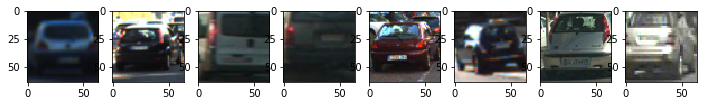

Examples of "not-cars" labeled images


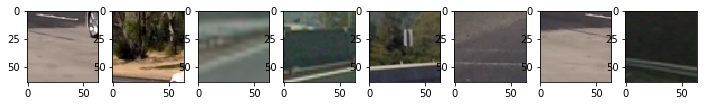

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from glob import glob
%matplotlib inline
import random


# Load labeled data set and save to a pickle file
vehicle_label_dir = 'labeled_images\\vehicles\\'
novehicle_label_dir = 'labeled_images\\non-vehicles\\'
cars = glob(vehicle_label_dir + '*\\*.png')
notcars = glob(novehicle_label_dir + '*\\*.png')

print('Number of labeled vehicle images = ', len(cars))
print('Number of labeled no-vehicle images = ', len(notcars))

# Show a sample of labeled images
num_ex = 8
#cars_sample = cars[np.random.random_integers(0,len(cars),num_ex)]
cars_sample = np.random.choice(cars, num_ex, replace=False)
notcars_sample = np.random.choice(notcars, num_ex, replace=False)

print()
print('Examples of "cars" labeled images')
plt.figure(figsize=(12,12))
for sample_idx in np.arange(num_ex):
    plt.subplot(1, num_ex, sample_idx + 1)
    sample_img = mpimg.imread(cars_sample[sample_idx])
    plt.imshow(sample_img)
plt.show()

print('Examples of "not-cars" labeled images')
plt.figure(figsize=(12,12))
for sample_idx in np.arange(num_ex):
    plt.subplot(1, num_ex, sample_idx + 1)
    sample_img = mpimg.imread(notcars_sample[sample_idx])
    plt.imshow(sample_img)
plt.show()

In [2]:
# Augment with CrowdAI data



### Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images

In [16]:
# Parameters
colorspace = 'GRAY' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb, GRAY
orient = 8
pix_per_cell = 16
cell_per_block = 1
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL" -- ignored if colorspace == 'GRAY'


from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import time


# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features


# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(img_paths, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0, visualize=False, feature_vec=True, img=None, ravel=True):
    # Create a list to append feature vectors to
    features = []
    feature_images = []
    # Iterate through the list of images
    for file in img_paths:
        if file == "single_image":
            image = np.copy(img)
        else:
            # Read in each one by one
            image = mpimg.imread(file)
        
        
        
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
            elif cspace == 'GRAY':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
                
                # Apply histogram equalization to account for lighting
                #feature_image = feature_image.astype(np.uint8)
                #feature_image  = cv2.equalizeHist(feature_image)
                
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if cspace == 'GRAY':
            if visualize == True:
                hog_features, feature_imgs = get_hog_features(feature_image, orient, 
                        pix_per_cell, cell_per_block, vis=True, feature_vec=feature_vec)
            else:
                hog_features = get_hog_features(feature_image, orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=feature_vec)
        elif hog_channel == 'ALL':
            hog_features = []
            feature_imgs = []
            for channel in range(feature_image.shape[2]):
                if visualize == True:
                    hog_features_indiv, feature_imgs_indiv = get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=True, feature_vec=feature_vec)
                    feature_imgs.append(feature_imgs_indiv)
                else:
                    hog_features_indiv = get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=feature_vec)
                    hog_features.append(hog_features_indiv)
            if ravel == True:
                hog_features = np.ravel(hog_features)      
        else:
            if visualize == True:
                hog_features, feature_imgs = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=True, feature_vec=feature_vec)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=feature_vec)

        # Append the new feature vector to the features list
        features.append(hog_features)
        if visualize == True:
            feature_images.append(feature_imgs)
    
    if visualize == True:
        # Return list of feature images
        return feature_images
    else:
        # Return list of feature vectors
        return features



In [12]:

# Feature extraction
print('Extracting features...')
t=time.time()
car_features = extract_features(cars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(notcars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')



Extracting features...


C:\Users\Jim\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


23.43 Seconds to extract HOG features...


### Visualization of HOG features

C:\Users\Jim\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Examples of "cars" labeled images


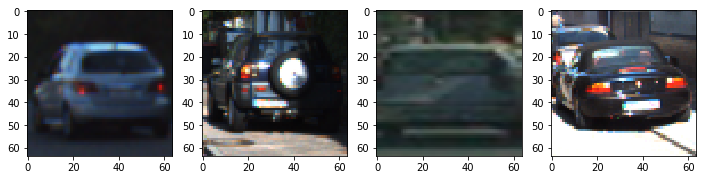

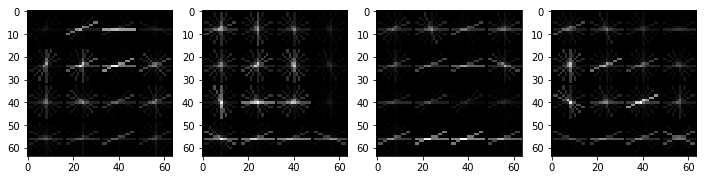

Examples of "not-cars" labeled images


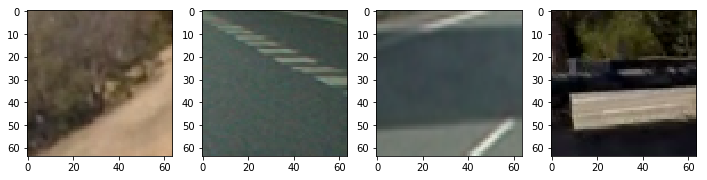

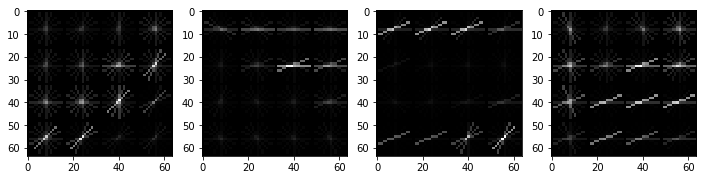

In [4]:
# Plot some examples of HOG features

num_ex = 4   #number of examples
cars_sample = np.random.choice(cars, num_ex, replace=False)
notcars_sample = np.random.choice(notcars, num_ex, replace=False)
car_features_sample = extract_features(cars_sample, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, visualize=True)
notcar_features_sample = extract_features(notcars_sample, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, visualize=True)


print('Examples of "cars" labeled images')

# Original images
plt.figure(figsize=(12,12))
for sample_idx in np.arange(num_ex):
    plt.subplot(1, num_ex, sample_idx + 1)
    sample_img = mpimg.imread(cars_sample[sample_idx])
    plt.imshow(sample_img)

# Features
plt.figure(figsize=(12,12))
for sample_idx in np.arange(num_ex):
    plt.subplot(1, num_ex, sample_idx + 1)
    plt.imshow(car_features_sample[sample_idx], cmap='gray')
plt.show()

print('Examples of "not-cars" labeled images')

# Original Images
plt.figure(figsize=(12,12))
for sample_idx in np.arange(num_ex):
    plt.subplot(1, num_ex, sample_idx + 1)
    sample_img = mpimg.imread(notcars_sample[sample_idx])
    plt.imshow(sample_img)

# Features
plt.figure(figsize=(12,12))
for sample_idx in np.arange(num_ex):
    plt.subplot(1, num_ex, sample_idx + 1)
    plt.imshow(notcar_features_sample[sample_idx], cmap='gray')
plt.show()


### Train a classifier Linear SVM classifier

In [5]:
from sklearn.svm import SVC

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
#svc = LinearSVC()
# Use a rbf SVC
svc = SVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')



Using: 8 orientations 16 pixels per cell and 1 cells per block
Feature vector length: 128
6.76 Seconds to train SVC...
Test Accuracy of SVC =  0.9887
My SVC predicts:  [ 0.  0.  1.  1.  0.  0.  0.  0.  1.  1.]
For these 10 labels:  [ 0.  0.  1.  1.  0.  0.  0.  0.  1.  1.]
0.0 Seconds to predict 10 labels with SVC


### Implement a sliding-window technique and use your trained classifier to search for vehicles in images.

In [17]:

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
    
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop = (0, x_start_stop[1])
    if x_start_stop[1] == None:
        x_start_stop = (x_start_stop[0], img.shape[1])
    if y_start_stop[0] == None:
        y_start_stop = (0, y_start_stop[1])
    if y_start_stop[1] == None:
        y_start_stop = (y_start_stop[0], img.shape[0])
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


# Function to use trained classifier with sliding window search
def sliding_window_search(img):
    
    img_features = extract_features(['single_image'], cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, feature_vec=False, img=img, ravel=False)
    
    print(np.shape(img_features))
    print(img_features)
    # Define small, medium and large window lists
    windows_sm = slide_window(img, x_start_stop=(None, None), y_start_stop=(int(0.5*test_img_shape[0]), int(0.75*test_img_shape[0])), 
                    xy_window=(80, 80), xy_overlap=(0.5, 0.5))

    windows_med = slide_window(img, x_start_stop=(None, None), y_start_stop=(int(0.5*test_img_shape[0]), int(0.8*test_img_shape[0])), 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.75))

    windows_lg = slide_window(img, x_start_stop=(30, None), y_start_stop=(int(0.5*test_img_shape[0]), int(0.9*test_img_shape[0])), 
                    xy_window=(185, 185), xy_overlap=(0.6, 0.75))
    
    # Iterate through window list
    window_list = np.concatenate((windows_sm, windows_med, windows_lg), axis=0)
    for window in window_list:
        #print(window)
        
        # Pass window through trained SVM
        
        y = svm.predict()
        
        



# Show example lattice of sliding windows with test image
test_img = mpimg.imread('test_images\\test4.jpg')
test_img_shape = np.shape(test_img)
sliding_window_search(test_img)
windows_sm = slide_window(test_img, x_start_stop=(None, None), y_start_stop=(int(0.5*test_img_shape[0]), int(0.75*test_img_shape[0])), 
                    xy_window=(80, 80), xy_overlap=(0.5, 0.5))

windows_med = slide_window(test_img, x_start_stop=(None, None), y_start_stop=(int(0.5*test_img_shape[0]), int(0.8*test_img_shape[0])), 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.75))

windows_lg = slide_window(test_img, x_start_stop=(30, None), y_start_stop=(int(0.5*test_img_shape[0]), int(0.9*test_img_shape[0])), 
                    xy_window=(185, 185), xy_overlap=(0.6, 0.75))
        
window_img = draw_boxes(test_img, windows_sm, color=(0, 0, 255), thick=6)    
window_img = draw_boxes(window_img, windows_med, color=(0, 255, 255), thick=6)    
window_img = draw_boxes(window_img, windows_lg, color=(0, 255, 0), thick=6)    


plt.figure(figsize=(12,12))
plt.imshow(window_img)
plt.title('Sliding Window Lattice on Sample Image')

C:\Users\Jim\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


(1, 45, 80, 1, 1, 8)
[array([[[[[ 0.03917765,  0.08019606,  0.10052508, ...,  0.00664474,
            0.00752412,  0.00526105]]],


        [[[ 0.00636138,  0.00222264,  0.00521058, ...,  0.00418605,
            0.00563756,  0.        ]]],


        [[[ 0.00771622,  0.00239574,  0.0042314 , ...,  0.00198561,
            0.00534838,  0.00083523]]],


        ..., 
        [[[ 0.12661463,  0.01596846,  0.21779164, ...,  0.07697064,
            0.21267607,  0.        ]]],


        [[[ 0.20026964,  0.05152103,  0.13969567, ...,  0.05580269,
            0.1433186 ,  0.03018758]]],


        [[[ 0.11637423,  0.02267324,  0.06593032, ...,  0.40097391,
            0.10630757,  0.04037933]]]],



       [[[[ 0.29125623,  0.09666693,  0.14929753, ...,  0.03282308,
            0.2019294 ,  0.02502158]]],


        [[[ 0.24005082,  0.03501476,  0.25925641, ...,  0.11120988,
            0.1092025 ,  0.        ]]],


        [[[ 0.16742271,  0.00769184,  0.18040385, ...,  0.01101084,
            0.

NameError: name 'svm' is not defined

In [9]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img
    
ystart = 400
ystop = 656
scale = 1.5
    
out_img = find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)


NameError: name 'spatial_size' is not defined

### Make a heat map to filter classifier detections

In [ ]:
heat = np.zeros_like(image[:,:,0]).astype(np.float)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap # Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()



def car_detection_pipeline(img):
    
    print()

### Run pipeline on video stream
(start with the test_video.mp4 and later implement on full project_video.mp4)

Create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    car_detection = car_detection_pipeline(image)
    
    #Combine with original image
    colorImage = weighted_img(laneDrawing, image)

    return colorImage


clip1 = VideoFileClip("test_video.mp4")
#clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

### Estimate a bounding box for vehicles detected.